
# Simple image classification with Lightning Flash

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-04-28T08:05:36.604152

This is a template to show simple image classification case if for some reason accelerator is required.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/templates/img-classify.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "torch>=1.6, <1.9" "torchmetrics>=0.6" "pytorch-lightning>=1.4" "seaborn" "pandas>=1.0" "matplotlib>=3.0" "ipython[notebook]" "lightning-flash[image]>=0.7"

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os

import flash
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from flash.image import ImageClassificationData, ImageClassifier
from IPython.core.display import display
from pytorch_lightning.loggers import CSVLogger

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
# this dataset is automatically downloaded and extracted based on meta link
# this archive includes the one more level - folder with the same name
DATA_HYMENOPLERA = os.path.join(PATH_DATASETS, "hymenoptera_data", "hymenoptera_data")

## 1. Create the DataModule

In [3]:
datamodule = ImageClassificationData.from_folders(
    train_folder=f"{DATA_HYMENOPLERA}/train/",
    val_folder=f"{DATA_HYMENOPLERA}/val/",
    batch_size=1024,
)

## 2. Build the task

In [4]:
model = ImageClassifier(backbone="resnet18", labels=datamodule.labels)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/AzDevOps_azpcontainer/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 3. Create the trainer and finetune the model

In [5]:
logger = CSVLogger(save_dir="logs/")
trainer = flash.Trainer(logger=logger, max_epochs=3, gpus=1)
trainer.finetune(model, datamodule=datamodule, strategy="freeze")

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | test_metrics  | ModuleDict     | 0     
3 | adapter       | DefaultAdapter | 11.2 M
-------------------------------------------------
10.6 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

,val_accuracy,val_cross_entropy,train_accuracy_epoch,train_cross_entropy_epoch
epoch,,,,
0,0.705882,0.596309,NaN,NaN
1,NaN,NaN,0.557377,0.717215
1,0.725490,0.553291,NaN,NaN
2,NaN,NaN,0.647541,0.631067
2,0.738562,0.520225,NaN,NaN


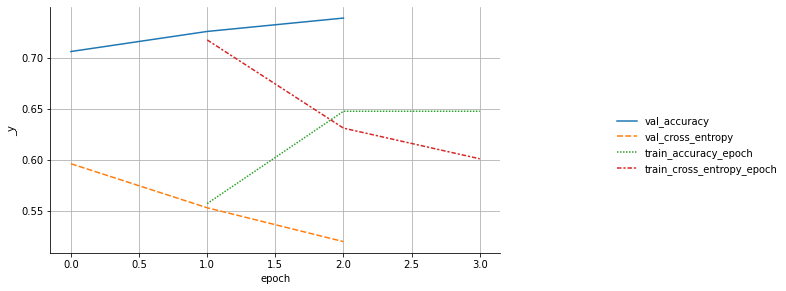

In [6]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())

g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()

## 4. Predict what's on a few images! ants or bees?

In [7]:
datamodule = ImageClassificationData.from_files(
    predict_files=[
        f"{DATA_HYMENOPLERA}/val/bees/65038344_52a45d090d.jpg",
        f"{DATA_HYMENOPLERA}/val/bees/590318879_68cf112861.jpg",
        f"{DATA_HYMENOPLERA}/val/ants/540543309_ddbb193ee5.jpg",
    ],
    batch_size=3,
)
predictions = trainer.predict(model, datamodule=datamodule, output="labels")
print(predictions)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1it [00:00, ?it/s]

[['bees', 'bees', 'bees']]


## 5. Save the model!

In [8]:
trainer.save_checkpoint("image_classification_model.pt")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[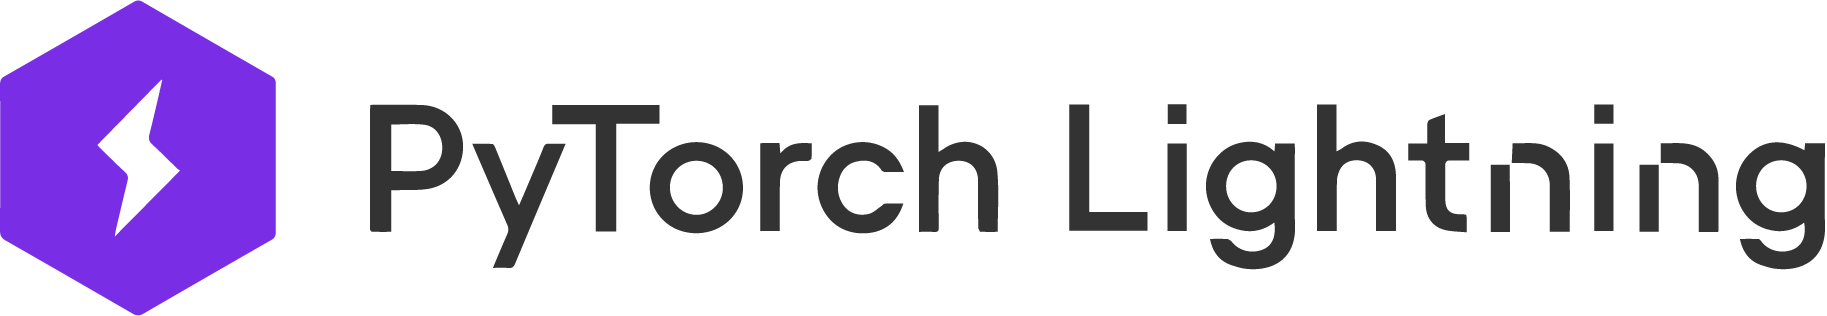{height="60px" width="240px"}](https://pytorchlightning.ai)